# Functional Encryption - Classification and information leakage

Our start point is the work on encrypted classification using Function Encryption of the paper [Reading in the Dark: Classifying Encrypted Digits with Functional Encryption](https://eprint.iacr.org/2018/206), and the associated [GitHub repository](https://github.com/edufoursans/reading-in-the-dark).

More specifically, the paper provides a new Functional Encryption scheme for quadratic multi-variate polynomials, which can under some hypothesis be seen as a single hidden layer neural network with a quadratic activation.
In the paper, the output corresponds to element per class, and it is made in clear. We analyse how this output can disclose information about the initial input or about charasteristics of this input.

To this aim, we have just built a dataset which is very similar to MNIST, used in the original paper but which is composed of 26 letter characters of 5 differents fonts. Our goal is two-fold:
 - Evaluate how the output in clear can be leverage with a public NN to make better prediction than a simple `argmax` function in the character recognition task.
 - Analyse to what extent the output in clear of the model trained for character recognition can reveal information about the font used, using an "adversarial" network.
 
Let's run a first evaluation of the model performance!

# 1 Quadratic model evaluation

We will first evaluate performances of the quadratic model alone, so for a neural network with a single hidden layer and a square activation function.

Let's load the dataset we just built

In [1]:
import pickle

train_data, train_target_char, train_target_family = [], [], []

# The training set
for i in range(6): 
    with open(f'character_dataset_train{i}.pkl', 'rb') as input_file:
        training_set = pickle.load(input_file)
        train_data_i, train_target_char_i, train_target_family_i = training_set
        train_data += train_data_i
        train_target_char += train_target_char_i
        train_target_family += train_target_family_i

# The testing set
with open(f'character_dataset_test.pkl', 'rb') as input_file:
    testing_set = pickle.load(input_file)
    test_data, test_target_char, test_target_family = testing_set
    
print('Training set', len(train_data), 'items')
print('Testing set ', len(test_data), 'items')

Training set 60000 items
Testing set  10000 items


In [2]:
from __future__ import print_function
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils

from torchvision import datasets, transforms

### Our quadratic model
Say hello to our model!

In [3]:
class QuadNet(nn.Module):
    def __init__(self, output_size):
        super(QuadNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, output_size)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return F.log_softmax(x, dim=1)

### Train and test functions

We now load a classic train and test function. Just notice that we add some manual regularisation as an optional parameter.

In [4]:
def train(args, model, train_loader, optimizer, epoch, reg_l2=None):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        
        # optional regularisation
        if reg_l2 is not None:
            regularization = reg_l2 * (
                model.proj1.bias.norm() ** 2 +
                model.proj1.weight.norm() ** 2 +
                model.diag1.bias.norm() ** 2 +
                model.diag1.weight.norm() ** 2
            )
            loss = loss + regularization

        loss.backward()
        optimizer.step()
        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))


def test(args, model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))
    
    return accuracy

### Last, the main loop

In [5]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 20
        self.lr = 0.01
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 300
        
def build_tensor_dataset(data, target):
    """Utility function to cast our data into a normalized torch TensorDataset"""
    normed_data = [(d - d.mean()) / d.std() for d in data]
    normed_data = torch.stack([torch.Tensor(d).reshape(1, 28, 28) for d in normed_data])
    target = torch.LongTensor([i[0] for i in target])
    tensor_dataset = utils.TensorDataset(normed_data, target)
    return tensor_dataset
    
def main(task='char', reg_l2=None):
    """
    You can choose to learn on:
    task=(char|family)
    With:
    regularisation_l2=(True|False)
    """
    args = Parser()
    torch.manual_seed(1)
    
    print('Learning on', task, 'with regularisation_l2', reg_l2)
    if task == 'family':
        train_target = train_target_family
        test_target = test_target_family
        output_size = 5
    elif task == 'char':
        train_target = train_target_char
        test_target = test_target_char
        output_size = 26
        
    train_dataset = build_tensor_dataset(train_data, train_target)
    test_dataset = build_tensor_dataset(test_data, test_target)
    
    train_loader = utils.DataLoader(
        train_dataset,
        batch_size=args.batch_size, shuffle=True
    )
    
    test_loader = utils.DataLoader(
        test_dataset,
        batch_size=args.test_batch_size, shuffle=True
    )
    
    model = QuadNet(output_size=output_size)
    
    # optimizer = optim.Adam(model.parameters(), lr=args.lr)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs = []
    for epoch in range(1, args.epochs + 1):
        train(args, model, train_loader, optimizer, epoch, reg_l2)
        if epoch <= args.epochs:
            test_perf = test(args, model, test_loader)
            test_perfs.append(test_perf)

    return test_perfs

### Accuracy results on the character recognition

In [6]:
results = {}
results['QuadNet'] = main()
reg_params = [0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01]
for reg_param in reg_params:
    results[f'QuadNet L2 Reg={reg_param}'] = main(reg_l2=reg_param)

Learning on char with regularisation_l2 None
Train Epoch: 1 [0/60000 (0%)]	Loss: 3.396022
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.923294
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.712726
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.526622

Test set: Average loss: 0.4016, Accuracy: 8855/10000 (88.55%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.288118
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.462003
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.363478
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.216865

Test set: Average loss: 0.2524, Accuracy: 9260/10000 (92.60%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.142714
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.453722
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.206338
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.088564

Test set: Average loss: 0.2368, Accuracy: 9302/10000 (93.02%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.042367
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.291792
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.175079
Train Epoch: 4 [57600/60000 (96%)

Train Epoch: 12 [19200/60000 (32%)]	Loss: 0.070556
Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.133827
Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.076186

Test set: Average loss: 0.1636, Accuracy: 9606/10000 (96.06%)

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.077601
Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.152539
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.165260
Train Epoch: 13 [57600/60000 (96%)]	Loss: 0.093911

Test set: Average loss: 0.1507, Accuracy: 9637/10000 (96.37%)

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.064680
Train Epoch: 14 [19200/60000 (32%)]	Loss: 0.085445
Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.091398
Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.147293

Test set: Average loss: 0.1601, Accuracy: 9611/10000 (96.11%)

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.071731
Train Epoch: 15 [19200/60000 (32%)]	Loss: 0.187562
Train Epoch: 15 [38400/60000 (64%)]	Loss: 0.104049
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.080364

Test set: Average loss: 0.1428, Accuracy: 9671/10000 (96.

Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.581016
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.321107
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.247502

Test set: Average loss: 0.2228, Accuracy: 9336/10000 (93.36%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.188746
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.407969
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.288523
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.276012

Test set: Average loss: 0.1782, Accuracy: 9498/10000 (94.98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.239031
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.286153
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.278800
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.212250

Test set: Average loss: 0.1588, Accuracy: 9552/10000 (95.52%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.303460
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.197005
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.189608
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.218120

Test set: Average loss: 0.1523, Accuracy: 9567/10000 (95.67%)

Train Epo

Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.224961

Test set: Average loss: 0.1333, Accuracy: 9617/10000 (96.17%)

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.208610
Train Epoch: 15 [19200/60000 (32%)]	Loss: 0.259776
Train Epoch: 15 [38400/60000 (64%)]	Loss: 0.298293
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.194864

Test set: Average loss: 0.1102, Accuracy: 9691/10000 (96.91%)

Train Epoch: 16 [0/60000 (0%)]	Loss: 0.208180
Train Epoch: 16 [19200/60000 (32%)]	Loss: 0.248488
Train Epoch: 16 [38400/60000 (64%)]	Loss: 0.231572
Train Epoch: 16 [57600/60000 (96%)]	Loss: 0.255187

Test set: Average loss: 0.1303, Accuracy: 9639/10000 (96.39%)

Train Epoch: 17 [0/60000 (0%)]	Loss: 0.220100
Train Epoch: 17 [19200/60000 (32%)]	Loss: 0.238113
Train Epoch: 17 [38400/60000 (64%)]	Loss: 0.208465
Train Epoch: 17 [57600/60000 (96%)]	Loss: 0.314290

Test set: Average loss: 0.1169, Accuracy: 9678/10000 (96.78%)

Train Epoch: 18 [0/60000 (0%)]	Loss: 0.268442
Train Epoch: 18 [19200/60000 (32%)]	Loss: 0.194163

Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.310475
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.322224
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.372407

Test set: Average loss: 0.1609, Accuracy: 9548/10000 (95.48%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.443442
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.397372
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.498060
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.344205

Test set: Average loss: 0.1830, Accuracy: 9449/10000 (94.49%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.341240
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.324191
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.357311
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.322906

Test set: Average loss: 0.1543, Accuracy: 9565/10000 (95.65%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.385252
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.342228
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.346047
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.371188

Test set: Average loss: 0.1523, Accuracy: 9540/10000 (95.40%)

Train Epo

Train Epoch: 17 [38400/60000 (64%)]	Loss: 0.444547
Train Epoch: 17 [57600/60000 (96%)]	Loss: 0.494266

Test set: Average loss: 0.1930, Accuracy: 9459/10000 (94.59%)

Train Epoch: 18 [0/60000 (0%)]	Loss: 0.635181
Train Epoch: 18 [19200/60000 (32%)]	Loss: 0.423726
Train Epoch: 18 [38400/60000 (64%)]	Loss: 0.466141
Train Epoch: 18 [57600/60000 (96%)]	Loss: 0.474204

Test set: Average loss: 0.1663, Accuracy: 9595/10000 (95.95%)

Train Epoch: 19 [0/60000 (0%)]	Loss: 0.452604
Train Epoch: 19 [19200/60000 (32%)]	Loss: 0.468874
Train Epoch: 19 [38400/60000 (64%)]	Loss: 0.553228
Train Epoch: 19 [57600/60000 (96%)]	Loss: 0.468411

Test set: Average loss: 0.1749, Accuracy: 9544/10000 (95.44%)

Train Epoch: 20 [0/60000 (0%)]	Loss: 0.465138
Train Epoch: 20 [19200/60000 (32%)]	Loss: 0.473058
Train Epoch: 20 [38400/60000 (64%)]	Loss: 0.519525
Train Epoch: 20 [57600/60000 (96%)]	Loss: 0.521416

Test set: Average loss: 0.1540, Accuracy: 9622/10000 (96.22%)



Let's display the results nicely!
We use a function which is already written in our module `learn`.

In [7]:
# chnage path to import parent modules
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))
import learn

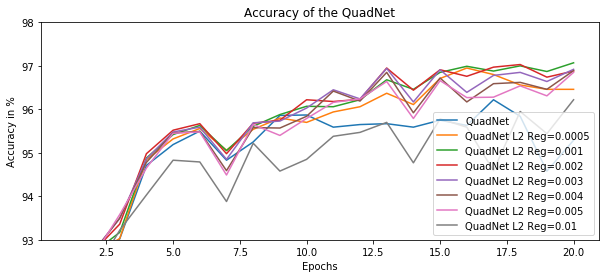

In [8]:
learn.show_results(results, 'Accuracy of the QuadNet', ymin=93, ymax=98)

We observe that a bit of regularisation is helpful and provides a 1% accuracy boost which is quite significant with these accuracies > 95%. We will keep the regularisation parameter `reg L2=0.001` and assess in the further experiment how this choice can evolve. Our reference accuracy is `96.96%` with regularisation (average on the last 5 epochs), and `95.51%` without.

**Discussion**


Since our dataset is not standard, you may want to know how this model performs compared to usual models. As a reference model, we suggest using the CNN given in the [official Pytorch tutorial on MNIST](https://github.com/pytorch/examples/blob/master/mnist/main.py) as we believe our dataset to be quite similar.

In [9]:
class CNN(nn.Module):
    def __init__(self, output_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, output_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In order to use it, we will add a parameter to our `main` `train` and `test` functions, which specifies the model type. Except this, nothing changes.

In [10]:
def train(args, model, train_loader, optimizer, epoch, model_type, reg_l2=None):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        if model_type == 'quad' and reg_l2 is not None:
            regularization = reg_l2 * (
                model.proj1.bias.norm() ** 2 +
                model.proj1.weight.norm() ** 2 +
                model.diag1.bias.norm() ** 2 +
                model.diag1.weight.norm() ** 2
            )
            loss = loss + regularization

        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))


def test(args, model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    acc = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), acc))
    
    return acc


def main(model_type, task='char', reg_l2=None, epochs=20):
    """
    You can choose to learn on:
    task=(char|family)
    model_type=(quad|cnn)
    """
    args = Parser()
    args.epochs = epochs
    torch.manual_seed(1)
    
    target_types = ['family', 'char']
    print('Learning on', task, 'with', model_type, 'and reg_l2' if reg_l2 else '')
    if task == 'family':
        train_target = train_target_family
        test_target = test_target_family
        output_size = 5
    elif task == 'char':
        train_target = train_target_char
        test_target = test_target_char
        output_size = 26
    
    train_dataset = build_tensor_dataset(train_data, train_target)
    test_dataset = build_tensor_dataset(test_data, test_target)
    
    train_loader = utils.DataLoader(
        train_dataset,
        batch_size=args.batch_size, shuffle=True
    )
    
    test_loader = utils.DataLoader(
        test_dataset,
        batch_size=args.test_batch_size, shuffle=True
    )
    assert model_type in ['quad', 'cnn']
    if model_type == 'quad':
        model = QuadNet(output_size=output_size)
    elif model_type == 'cnn':
        model = CNN(output_size=output_size)

    # optimizer = optim.Adam(model.parameters(), lr=args.lr)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs = []
    for epoch in range(1, args.epochs + 1):
        train(args, model, train_loader, optimizer, epoch, model_type, reg_l2)
        if epoch <= args.epochs:
            test_perf = test(args, model, test_loader)
            test_perfs.append(test_perf)
        
    return test_perfs

In [11]:
results_cnn = {}
results_cnn['QuadNet (without L2 reg)'] = main(model_type='quad')
results_cnn['QuadNet (L2 Reg=0.001)'] = main(model_type='quad', reg_l2=0.001)
results_cnn['CNN'] = main(model_type='cnn')

Learning on char with quad 
Train Epoch: 1 [0/60000 (0%)]	Loss: 3.396022
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.923294
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.712726
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.526622

Test set: Average loss: 0.4016, Accuracy: 8855/10000 (88.55%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.288118
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.462003
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.363478
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.216865

Test set: Average loss: 0.2524, Accuracy: 9260/10000 (92.60%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.142714
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.453722
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.206338
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.088564

Test set: Average loss: 0.2368, Accuracy: 9302/10000 (93.02%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.042367
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.291792
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.175079
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.155754


Train Epoch: 12 [19200/60000 (32%)]	Loss: 0.103279
Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.195629
Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.126817

Test set: Average loss: 0.1453, Accuracy: 9622/10000 (96.22%)

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.112102
Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.170523
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.164040
Train Epoch: 13 [57600/60000 (96%)]	Loss: 0.152076

Test set: Average loss: 0.1260, Accuracy: 9668/10000 (96.68%)

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.115267
Train Epoch: 14 [19200/60000 (32%)]	Loss: 0.125967
Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.141434
Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.168182

Test set: Average loss: 0.1384, Accuracy: 9646/10000 (96.46%)

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.106629
Train Epoch: 15 [19200/60000 (32%)]	Loss: 0.195233
Train Epoch: 15 [38400/60000 (64%)]	Loss: 0.133780
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.111908

Test set: Average loss: 0.1237, Accuracy: 9685/10000 (96.

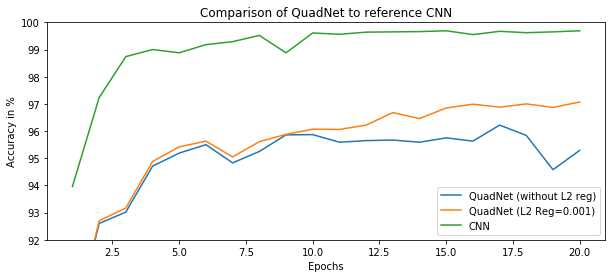

In [12]:
learn.show_results(results_cnn, 'Comparison of QuadNet to reference CNN', ymin=92, ymax=100)

As you can see our model is significantly outperformed by the baseline CNN, which is expected as it remains a very simple network. For the sake fo curiosity, we will also train it on the other tasks, which is the family recognition, and we will report results compared to the CNN.

### Accuracy results on the family recognition

In [21]:
family_results = {}
family_results['QuadNet Comp on Family rec.'] = main(model_type='quad', task='family', epochs=20)
family_results['CNN on Family rec'] = main(model_type='cnn', task='family', epochs=20)

Training set 60000 items
Testing set  10000 items
Learning on family with quad 
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.817240
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.363673
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.346390
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.117785

Test set: Average loss: 1.0845, Accuracy: 5501/10000 (55.01%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.131609
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.079811
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.169021
Train Epoch: 2 [57600/60000 (96%)]	Loss: 1.034983

Test set: Average loss: 0.9930, Accuracy: 5963/10000 (59.63%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.013811
Train Epoch: 3 [19200/60000 (32%)]	Loss: 1.119279
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.798005
Train Epoch: 3 [57600/60000 (96%)]	Loss: 1.286672

Test set: Average loss: 0.9618, Accuracy: 6128/10000 (61.28%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.096636
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.915666
Train Epoch: 4 [38400/60000 (64%)]	Loss: 1.12761

Train Epoch: 12 [19200/60000 (32%)]	Loss: 0.009338
Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.029599
Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.013506

Test set: Average loss: 0.0714, Accuracy: 9773/10000 (97.73%)

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.000774
Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.002527
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.175407
Train Epoch: 13 [57600/60000 (96%)]	Loss: 0.009227

Test set: Average loss: 0.0800, Accuracy: 9742/10000 (97.42%)

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.040304
Train Epoch: 14 [19200/60000 (32%)]	Loss: 0.063686
Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.017806
Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.008497

Test set: Average loss: 0.0649, Accuracy: 9803/10000 (98.03%)

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.005672
Train Epoch: 15 [19200/60000 (32%)]	Loss: 0.002235
Train Epoch: 15 [38400/60000 (64%)]	Loss: 0.082303
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.006970

Test set: Average loss: 0.0695, Accuracy: 9791/10000 (97.

If you have some time, you can run variants with regularization, but Disclaimer! it doesn't improve the model accuracy.

In [14]:
#reg_params = [0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01]
#for reg_param in reg_params:
#    family_results[f'QuadNet Comp on Family rec. (with L2 Reg={reg_param})'] = main(
#        model_type='quad', task='family', reg_l2=reg_param, epochs=20
#    )
    

However, we will change the actual optimizer and its hyper parameters to try improving the model performance.
We will use the `main` function provided in our `learn` module, which performs similarly to the one described above, except you can provide your own optimizer.

In [15]:
from learn import main
from learn.models import QuadNet
import torch.optim as optim

In [16]:
hyperparam_results = {}
learning_rates = [0.001, 0.002, 0.005, 0.01]
momento = [0, 0.1, 0.5]
for lr in learning_rates:
    for momentum in momento:
        model = QuadNet(output_size=5)
        opt = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        hyperparam_results[f'QuadNet Family rec. (lr={lr}, mom.={momentum})'] = main(
            model_type='quad', model=model, optimizer=opt, task='family', epochs=20
        )

Training set 60000 items
Testing set  10000 items
Learning on family with quad 
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.892021
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.702145
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.571092
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.687135

Test set: Average loss: 1.4891, Accuracy: 3446/10000 (34.46%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.629640
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.632945
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.559155
Train Epoch: 2 [57600/60000 (96%)]	Loss: 1.483282

Test set: Average loss: 1.4032, Accuracy: 4035/10000 (40.35%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.501094
Train Epoch: 3 [19200/60000 (32%)]	Loss: 1.456140
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.416731
Train Epoch: 3 [57600/60000 (96%)]	Loss: 1.568119

Test set: Average loss: 1.3382, Accuracy: 4445/10000 (44.45%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.512115
Train Epoch: 4 [19200/60000 (32%)]	Loss: 1.385960
Train Epoch: 4 [38400/60000 (64%)]	Loss: 1.37458

Train Epoch: 12 [19200/60000 (32%)]	Loss: 1.070407
Train Epoch: 12 [38400/60000 (64%)]	Loss: 1.269330
Train Epoch: 12 [57600/60000 (96%)]	Loss: 1.211675

Test set: Average loss: 1.0455, Accuracy: 5840/10000 (58.40%)

Train Epoch: 13 [0/60000 (0%)]	Loss: 1.165053
Train Epoch: 13 [19200/60000 (32%)]	Loss: 1.179273
Train Epoch: 13 [38400/60000 (64%)]	Loss: 1.172556
Train Epoch: 13 [57600/60000 (96%)]	Loss: 1.252430

Test set: Average loss: 1.0328, Accuracy: 5883/10000 (58.83%)

Train Epoch: 14 [0/60000 (0%)]	Loss: 1.288635
Train Epoch: 14 [19200/60000 (32%)]	Loss: 1.356189
Train Epoch: 14 [38400/60000 (64%)]	Loss: 1.172591
Train Epoch: 14 [57600/60000 (96%)]	Loss: 1.196533

Test set: Average loss: 1.0185, Accuracy: 5893/10000 (58.93%)

Train Epoch: 15 [0/60000 (0%)]	Loss: 1.158721
Train Epoch: 15 [19200/60000 (32%)]	Loss: 1.164507
Train Epoch: 15 [38400/60000 (64%)]	Loss: 1.026222
Train Epoch: 15 [57600/60000 (96%)]	Loss: 1.102340

Test set: Average loss: 1.0077, Accuracy: 5992/10000 (59.

Train Epoch: 3 [19200/60000 (32%)]	Loss: 1.357462
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.306360
Train Epoch: 3 [57600/60000 (96%)]	Loss: 1.505034

Test set: Average loss: 1.2296, Accuracy: 5047/10000 (50.47%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.321501
Train Epoch: 4 [19200/60000 (32%)]	Loss: 1.264577
Train Epoch: 4 [38400/60000 (64%)]	Loss: 1.248097
Train Epoch: 4 [57600/60000 (96%)]	Loss: 1.326105

Test set: Average loss: 1.1592, Accuracy: 5296/10000 (52.96%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 1.309408
Train Epoch: 5 [19200/60000 (32%)]	Loss: 1.473131
Train Epoch: 5 [38400/60000 (64%)]	Loss: 1.302963
Train Epoch: 5 [57600/60000 (96%)]	Loss: 1.344252

Test set: Average loss: 1.1148, Accuracy: 5555/10000 (55.55%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 1.216251
Train Epoch: 6 [19200/60000 (32%)]	Loss: 1.238378
Train Epoch: 6 [38400/60000 (64%)]	Loss: 1.284729
Train Epoch: 6 [57600/60000 (96%)]	Loss: 1.034489

Test set: Average loss: 1.0705, Accuracy: 5746/10000 (57.46%)

Train Epo

Train Epoch: 14 [38400/60000 (64%)]	Loss: 1.078116
Train Epoch: 14 [57600/60000 (96%)]	Loss: 1.058775

Test set: Average loss: 0.9263, Accuracy: 6349/10000 (63.49%)

Train Epoch: 15 [0/60000 (0%)]	Loss: 1.046911
Train Epoch: 15 [19200/60000 (32%)]	Loss: 1.025500
Train Epoch: 15 [38400/60000 (64%)]	Loss: 0.906524
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.942931

Test set: Average loss: 0.9228, Accuracy: 6383/10000 (63.83%)

Train Epoch: 16 [0/60000 (0%)]	Loss: 0.944769
Train Epoch: 16 [19200/60000 (32%)]	Loss: 1.138580
Train Epoch: 16 [38400/60000 (64%)]	Loss: 0.972743
Train Epoch: 16 [57600/60000 (96%)]	Loss: 1.052114

Test set: Average loss: 0.9181, Accuracy: 6381/10000 (63.81%)

Train Epoch: 17 [0/60000 (0%)]	Loss: 1.062138
Train Epoch: 17 [19200/60000 (32%)]	Loss: 0.977490
Train Epoch: 17 [38400/60000 (64%)]	Loss: 0.948487
Train Epoch: 17 [57600/60000 (96%)]	Loss: 0.949854

Test set: Average loss: 0.9127, Accuracy: 6462/10000 (64.62%)

Train Epoch: 18 [0/60000 (0%)]	Loss: 0.935441

Train Epoch: 5 [19200/60000 (32%)]	Loss: 1.323258
Train Epoch: 5 [38400/60000 (64%)]	Loss: 1.136750
Train Epoch: 5 [57600/60000 (96%)]	Loss: 1.127083

Test set: Average loss: 1.0005, Accuracy: 6047/10000 (60.47%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.990607
Train Epoch: 6 [19200/60000 (32%)]	Loss: 1.100695
Train Epoch: 6 [38400/60000 (64%)]	Loss: 1.190677
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.964034

Test set: Average loss: 0.9660, Accuracy: 6190/10000 (61.90%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 1.126151
Train Epoch: 7 [19200/60000 (32%)]	Loss: 1.107616
Train Epoch: 7 [38400/60000 (64%)]	Loss: 1.066653
Train Epoch: 7 [57600/60000 (96%)]	Loss: 1.086610

Test set: Average loss: 0.9371, Accuracy: 6331/10000 (63.31%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.852780
Train Epoch: 8 [19200/60000 (32%)]	Loss: 1.108035
Train Epoch: 8 [38400/60000 (64%)]	Loss: 1.044203
Train Epoch: 8 [57600/60000 (96%)]	Loss: 1.018039

Test set: Average loss: 0.9420, Accuracy: 6275/10000 (62.75%)

Train Epo

Train Epoch: 16 [38400/60000 (64%)]	Loss: 0.926732
Train Epoch: 16 [57600/60000 (96%)]	Loss: 1.053825

Test set: Average loss: 0.8706, Accuracy: 6617/10000 (66.17%)

Train Epoch: 17 [0/60000 (0%)]	Loss: 0.962738
Train Epoch: 17 [19200/60000 (32%)]	Loss: 0.879548
Train Epoch: 17 [38400/60000 (64%)]	Loss: 0.923811
Train Epoch: 17 [57600/60000 (96%)]	Loss: 0.910511

Test set: Average loss: 0.8854, Accuracy: 6576/10000 (65.76%)

Train Epoch: 18 [0/60000 (0%)]	Loss: 0.922995
Train Epoch: 18 [19200/60000 (32%)]	Loss: 0.973569
Train Epoch: 18 [38400/60000 (64%)]	Loss: 1.043814
Train Epoch: 18 [57600/60000 (96%)]	Loss: 1.038541

Test set: Average loss: 0.8709, Accuracy: 6581/10000 (65.81%)

Train Epoch: 19 [0/60000 (0%)]	Loss: 1.055143
Train Epoch: 19 [19200/60000 (32%)]	Loss: 0.944206
Train Epoch: 19 [38400/60000 (64%)]	Loss: 1.016993
Train Epoch: 19 [57600/60000 (96%)]	Loss: 1.103261

Test set: Average loss: 0.8769, Accuracy: 6582/10000 (65.82%)

Train Epoch: 20 [0/60000 (0%)]	Loss: 0.833248

Train Epoch: 7 [19200/60000 (32%)]	Loss: 1.068278
Train Epoch: 7 [38400/60000 (64%)]	Loss: 1.013517
Train Epoch: 7 [57600/60000 (96%)]	Loss: 1.038598

Test set: Average loss: 0.9279, Accuracy: 6407/10000 (64.07%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.838950
Train Epoch: 8 [19200/60000 (32%)]	Loss: 1.102805
Train Epoch: 8 [38400/60000 (64%)]	Loss: 1.074227
Train Epoch: 8 [57600/60000 (96%)]	Loss: 1.099685

Test set: Average loss: 0.9279, Accuracy: 6383/10000 (63.83%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 1.149890
Train Epoch: 9 [19200/60000 (32%)]	Loss: 1.105462
Train Epoch: 9 [38400/60000 (64%)]	Loss: 1.114191
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.972523

Test set: Average loss: 0.9084, Accuracy: 6442/10000 (64.42%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.886882
Train Epoch: 10 [19200/60000 (32%)]	Loss: 1.046096
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.963543
Train Epoch: 10 [57600/60000 (96%)]	Loss: 1.021673

Test set: Average loss: 0.9404, Accuracy: 6168/10000 (61.68%)

Train

Train Epoch: 18 [38400/60000 (64%)]	Loss: 1.163787
Train Epoch: 18 [57600/60000 (96%)]	Loss: 1.070459

Test set: Average loss: 0.9016, Accuracy: 6441/10000 (64.41%)

Train Epoch: 19 [0/60000 (0%)]	Loss: 1.171188
Train Epoch: 19 [19200/60000 (32%)]	Loss: 1.001114
Train Epoch: 19 [38400/60000 (64%)]	Loss: 1.085417
Train Epoch: 19 [57600/60000 (96%)]	Loss: 1.136781

Test set: Average loss: 0.9650, Accuracy: 6222/10000 (62.22%)

Train Epoch: 20 [0/60000 (0%)]	Loss: 0.923339
Train Epoch: 20 [19200/60000 (32%)]	Loss: 1.069925
Train Epoch: 20 [38400/60000 (64%)]	Loss: 1.160883
Train Epoch: 20 [57600/60000 (96%)]	Loss: 1.176447

Test set: Average loss: 0.8912, Accuracy: 6522/10000 (65.22%)

Training set 60000 items
Testing set  10000 items
Learning on family with quad 
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.746947
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.425288
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.170841
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.421949

Test set: Average loss: 1.0926, 

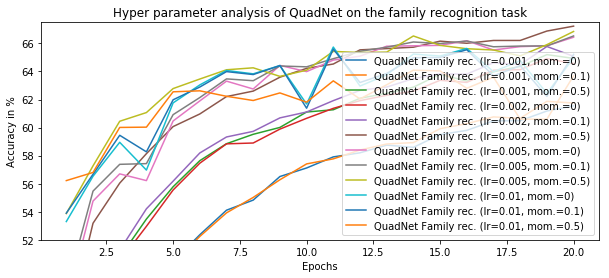

In [17]:
title = 'Hyper parameter analysis of QuadNet on the family recognition task'
learn.show_results(hyperparam_results, title, ymin=52, ymax=67.5)

**Observation** The higher the learning rate is, the less smooth the learning curve is.

This hyperparameter tuning suggests that the setting `(lr=0.002, mom.=0.5)` can help doing a `+4%` accuracy at `66.51%` (averaged on the 5 last epochs), compared to `62.26%` on the baseline `(lr=0.01, mom.=0.5)`. This helps but remains really unsufficient compared to CNN.

In [18]:
lr = 0.002
momentum = 0.5
family_results[f'QuadNet Family rec. (lr={lr}, mom.={momentum})'] = hyperparam_results[f'QuadNet Family rec. (lr={lr}, mom.={momentum})']

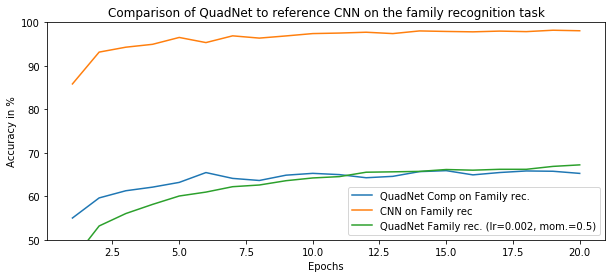

In [26]:
title = 'Comparison of QuadNet to reference CNN on the family recognition task'
learn.show_results(family_results, title, ymin=50, ymax=100)

**Conclusion on family recognition**

In this task, we can observe that the Quadratic network is not suited to this kind of training, because of its simplicity, while the CNN performs really well.

The next question for us is: can we use the output of the quadratic net to feed another network to make a better prediction than the simple argmax we're currently performing?
We will provide an extended analysis of models that we can put on top to improve the global accuracy in Part 3.